## Use case: Using glaciers and their mass changes as indicators for climatic changes at the global scale in the context of the current global warming

## Quality assessment question: "Does the dataset have adequate spatial/temporal resolution, coverage (extent) and sampling density to derive multi-year trends in glacier mass changes, hereby enabling their use as indicators of global climate change?"

Glaciers are a major contributor to current global sea-level rise, a resource of fresh water, a potential threat of natural hazards, and an important factor for hydro-power production and runoff, as well as for recreation and tourism. A proper assessment of glacier mass changes due to warming climatic conditions therefore plays a crucial role in dealing with these issues. In that regard, the 'Glacier mass change gridded data from 1976 to present derived from the Fluctuations of Glaciers Database' dataset provides key information with respect to glacier mass change data at various spatial and temporal scales. The dataset on the CDS is based on the Fluctuations of Glaciers (FoG) dataset (here we use version 2023-09), which are currently the most complete available datasets in terms of glacier mass changes, with a global coverage. It is a compilation of research data from in-situ, air and spaceborne methods (e.g. WGMS, 2022; Berthier et al., 2023), which have been put together and organized into one single gridded dataset. However, several known issues still persist in the dataset of which the user should take note before using the product. This notebook investigates how well the glacier mass change dataset (here we use version 2023-09) can be used as an indicator for climatic changes at the global scale. More specifically, the notebook evaluates whether the dataset is of sufficient maturity and quality for that purpose in terms of its spatial and temporal resolution and coverage (extent). When measured over a long period and at extended geographical scales, trends in glacier mass balance can namely be considered a clear indicator of global climate change.

### Quality assessment statement

- The glaciers mass change dataset that is on the CDS is currently the most complete dataset of glacier mass change data in terms of its spatial coverage. It is generally considered the main reference dataset to determine the glaciers mass change across the globe.
- The data can be considered highly mature and complete in terms of its spatial and temporal coverage. The glacier mass change products are at this stage therefore found to be highly suitable to derive statistical properties such as mean, variability and trends (and hence to deduce climate change signals), as there are no spatial/temporal gaps in the data series, the temporal resolution is consistent at a yearly basis, and the number of consecutive years (the data record length) is sufficient (> 30 years) to filter out inter-annual variability. The gridded nature of the dataset furthermore allows to monitor climate change on the local, regional and global scale.
- In other words, the dataset is found to be highly suitable to monitor and derive global (cumulative) mass changes in space and time and to, for example, use the glacier mass change data as climate change indicators in the context of climate change monitoring. The dataset has thus sufficient quality in terms of its spatial (0.5 degrees) and temporal (annual) resolution (when compared to the minimum GCOS requirements) and spatial (i.e. global) and temporal (i.e. since 1975-76) coverage/extent, as there are no data gaps. 
- When using the glacier mass change dataset that is available on the CDS, users should be aware of other typical problems with the dataset. One of such problems is the fact that data can not be consulted at the individual glacier-scale and that it is hence impossible to determine the number of sampled glaciers in a particular year for which mass or elevation changes and their error estimates are available. This lacking info can impact the quality and suitability of the data for similar glaciological, hydrological, and climatological applications, such as for example for the purpose of water resource management at the local (individual glaciers) scale. Data were furthermore measured and generated by different institutes/research groups and from different methods (i.e. the in-situ glaciological and satellite-based geodetic methods). As such, they were (with a high degree of certainty) not compiled in a fully consistent way for the entire dataset.

### Methodology

#### Short description

The mass balance of a glacier is the difference between mass gained (from snow accumulation) and mass lost (by melting/runoff or ice discharge into lakes/the ocean), which is the same as the net mass change of a glacier. In general, the basis for the derived gridded mass changes are individual measurements (mainly glaciological in-situ annual surface mass balance data) and geodetic spaceborne elevation change data (an average elevation/ice thickness change or total annual ice volume change value), that are converted into an averaged specific mass balance value (i.e. for the entire glacier, mostly reported with units m w.e.) for every individual glacier. Afterwards, the data are submitted to the World Glacier Monitoring Service (WGMS). Further processing of the data results in a gridded (0.5° global grid) glacier mass change product with global coverage and dating back until the 1975-76 hydrological year. Each grid cell therefore contains a time series of total glacier mass change data (in Gt yr⁻¹ or m w.e. yr⁻¹) of all glaciers within the specific grid cell. In this notebook, we ue version 2023-09. For a more detailed description of the data acquisition and processing methods, we refer to the documentation on the CDS and the ECMWF Confluence Wiki.

#### Structure and (sub)sections

In this notebook, the applicability of glacier mass change data to used as indicators for climatic changes at the global scale in the context of the current global warming will be assessed. We will furthermore check whether the data are of sufficient adequacy in terms of its spatial/temporal resolution and coverage to be used for this purpose. This will be realized by analyzing the spatial and temporal characteristics of linear and quadratic glacier mass change trends, by assessing the spatial and temporal coverage of the dataset, by discussing other potential limitations and error sources of the dataset, and by evaluating the implications for the usage of the data in terms of the specific use case and question (i.e. using glacier mass changes as indicators for climate change at the global scale). The structure is as follows:

- **Data preparation and processing**: This section loads packages, defines requests for download from the CDS, downloads the actual data and inspects the data to reveal its structure. Also the functions that are used in this notebook are defined in this section.
- **Analysis of sampling density and spatio-temporal resolution/extent of glacier mass changes**: This section discusses the temporal and geographical coverage of the data in the glacier mass change product. We discuss the length of the time series, and compare values for the glacier area (that are used as input for the glacier mass change calculations) and the trend over time, to values from other reference datasets and the literature. At last, we briefly discuss the sampling density.
- **Spatial distribution of glacier mass change (linear and quadratic) trends**: This section derives the cumulative sum as well as linear and quadratic (accelerations) glacier mass change trends since 1975-76 and plots them a world map to discuss its spatial patterns and statistical significance.

## Analysis and results

### Data preparation and processing

First we load the packages:

In [127]:
import fsspec
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xarray as xr
import rasterio.features
from rasterio.transform import from_origin
from scipy.stats import linregress
import xskillscore as xs
import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/verhaegen_yoni/.cdsapirc")
from c3s_eqc_automatic_quality_control import download

plt.style.use("seaborn-v0_8-notebook")

Then we define the parameters, i.e. for which years we want the glacier mass change data to be downloaded:

In [128]:
period_start = "1975_1976"
period_stop = "2021_2022"
assert all("_" in period and len(period) == 9 for period in (period_start, period_stop))

Define a function to calculate the sum, linear trend and acceleration:

In [129]:
def compute_coeff_and_pvalue(cumsum, degree):
    coeff = cumsum.polyfit("time", degree)
    (fit,) = xr.polyval(cumsum["time"], coeff).data_vars.values()
    p_value = xs.pearson_r_p_value(cumsum.chunk(time=-1), fit.chunk(time=-1), "time")
    return coeff, p_value

def compute_time_statistics(ds):
    with xr.set_options(keep_attrs=True):
        cumsum = ds["glacier_mass_change_gt"].cumsum("time").drop_vars("time")
        ds["uncertainty_gt"] = (ds["uncertainty_gt"] ** 2).sum("time") ** (1 / 2)
        non_nan_counts = ds["glacier_mass_change_gt"].count(dim="time").where(ds["glacier_mass_change_gt"].count(dim="time") != 0)

    # Sum
    ds = ds.sum("time", keep_attrs=True)
    for da in ds.data_vars.values():
        da.attrs["long_name"] = f"Sum of {da.attrs['long_name']}"

    # Linear
    coeff, p_value = compute_coeff_and_pvalue(cumsum, 1)
    ds["Slope"] = coeff["polyfit_coefficients"].sel(degree=1)
    ds["Slope"].attrs = {
        "long_name": f"Linear trend of {da.attrs['long_name']}",
        "units": f"{da.attrs['units']} yr$^{-1}$",
    }
    ds["Pvalue1"] = p_value
    ds["Pvalue1"].attrs = {
        "long_name": f"Linear p-value of {da.attrs['long_name']}",
    }

    # Quadratic
    coeff, p_value = compute_coeff_and_pvalue(cumsum, 2)
    ds["Acceleration"] = 2 * coeff["polyfit_coefficients"].sel(degree=2)
    ds["Acceleration"].attrs = {
        "long_name": f"Quadratic trend of {da.attrs['long_name']}",
        "units": f"{da.attrs['units']} yr$^{-2}$",
    }
    ds["Pvalue2"] = p_value
    ds["Pvalue2"].attrs = {
        "long_name": f"Quadratic p-value of {da.attrs['long_name']}",
    }

    return ds

def compute_spatial_statistics(ds):
    with xr.set_options(keep_attrs=True):
        return ds.sum(("latitude", "longitude"))

Then we define requests for download from the CDS and download and transform the glacier mass change data.

In [130]:
# Set request
y0_start, y1_start = map(int, period_start.split("_"))
y0_stop, y1_stop = map(int, period_stop.split("_"))
collection_id = "derived-gridded-glacier-mass-change"
request = {
    "variable": "glacier_mass_change",
    "product_version": "wgms_fog_2023_09",
    "format": "zip",
    "hydrological_year": [
        f"{y0}_{str(y1)[-2:]}"
        for y0, y1 in zip(range(y0_start, y0_stop + 1), range(y1_start, y1_stop + 1))
    ],
}

# Download glacier mass change data
print("Downloading and handling glacier mass change data...")

chunks = {"hydrological_year": 1}
ds = download.download_and_transform(
    collection_id,
    request,
    chunks=chunks,
    transform_func=compute_time_statistics,
    transform_chunks=False,
)
ds_timeseries = download.download_and_transform(
    collection_id,
    request,
)

# Customize some attributes
for obj in (ds, ds_timeseries):
    for da in obj.data_vars.values():
        da.attrs["long_name"] = da.attrs["long_name"].replace("_", " ").title()

print("Downloading and data handling done.")

100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Let us inspect the data:

In [131]:
ds_timeseries

<xarray.Dataset> Size: 487MB
Dimensions:                  (time: 47, latitude: 360, longitude: 720)
Coordinates:
  * time                     (time) datetime64[ns] 376B 1976-01-01 ... 2022-0...
  * latitude                 (latitude) float64 3kB 89.75 89.25 ... -89.75
  * longitude                (longitude) float64 6kB -179.8 -179.2 ... 179.8
Data variables:
    glacier_mass_change_gt   (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    glacier_mass_change_mwe  (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    glacier_area_km2         (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    uncertainty_gt           (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    uncertainty_mwe          (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    title:                 Global gridded annual glacier mass changes
    data_version:          version-wgms-fog-2023-09
    project:               Copernicus Climate Change Service (C3S) Essential ...
    institution:           World Glacier Monitoring Service - Geography Depar...
    created_by:            Dr. Ines Dussaillant - ines.dussaillant@geo.uzh.ch
    references:            Fluctuation of Glaciers (FoG) database version wgm...
    citation:              Dussaillant, I., Bannwart, J., Paul, F., Zemp, M. ...
    conventions:           CF Version CF-1.8
    dataset_description:   Horizontal resolution: 0.5° (latitude - longitude)...
    dataset_limitations:   Grid-point artefact in polar regions: see Algorith...
    dataset_improvements:  Improvements of product version WGMS-FOG-2023-09 w...
    comments:              Conversions between annual grid point mass change ...

The dataset is a gridded dataset at a 0.5 by 0.5 degree spatial resolution containing annual values of the total glacier mass change (in Gt) of a grid cell (`glacier_mass_change_gt`) and its uncertainty (`uncertainty_gt`) since the 1975-76 hydrological year. Mass changes and their uncertainty can also be extracted in units of m water equivalent (`glacier_mass_change_mwe`). Note that not all grid cells exhibit the same absolute total surface area (glacierized and non-glacierized), as grid cells get smaller towards the poles. The parameterized absolute glacier surface area is furthermore also available in this dataset by the variabile `glacier_area_km2`. 

### Analysis of sampling density and spatio-temporal resolution/extent of glacier mass changes

Let us print some attributes of the dataset to reveal its spatial and temporal resolution, as well as the temporal coverage/extent:

In [124]:
print(ds.attrs['dataset_description'])

Horizontal resolution: 0.5° (latitude - longitude), GCS_WGS_1984Temporal resolution: Annual, hydrological yearTemporal coverage: 1975/76-2021/22Observational sample: 96% of world glaciers with valid observations


The dataset has a spatial resolution 0.5 degrees and a temporal resolution of 1 hydrological year. Although no specific thresholds are given for the spatial resolution of glacier mass change data by GCOS (2022), the annual temporal resolution satisfies the minimum threshold. The goal would, however, be to have glacier mass changes at monthly time scales (GCOS, 2022). Let us examine the temporal extent of the dataset:

In [136]:
print(f"The temporal extent of the glacier mass change dataset is {np.shape(ds_timeseries['time'])[0]} years.")

The temporal extent of the glacier mass change dataset is 47 years.


To determine whether the temporal extent of the glacier mass change dataset is sufficient to capture multi-year trends in global glacier mass changes and to use these trends as indicators of climatic changes, we turn to the literature. The Intergovernmental Panel on Climate Change (IPCC) often uses 30 years as a standard period for climate normals and trend analysis to ensure that the analysis captures meaningful climatic changes rather than short-term (intra/interannual) fluctuations. We therefore consider these guidelines to be likewise applicative for glacier mass changes. When measured over a long period (> 30 years), trends in glacier mass balance can therefore be considered an indicator of global climate change. Longer periods, as is here the case, provide even more robust trend estimates and reduce the influence of short-term variability.

To have an idea of the temporal coverage, we can plot the number of years that hold non-NaN mass change data for each pixel. If the pixel exhibits complete temporal coverage, the value should equal the number of years in the time dimension `time` of the dataset. In the map below, pixels where the time series of glacier mass change data has an amout of non-NaN values that equal the number of years in the time dimension of the data array are colored green, else they are colored red:

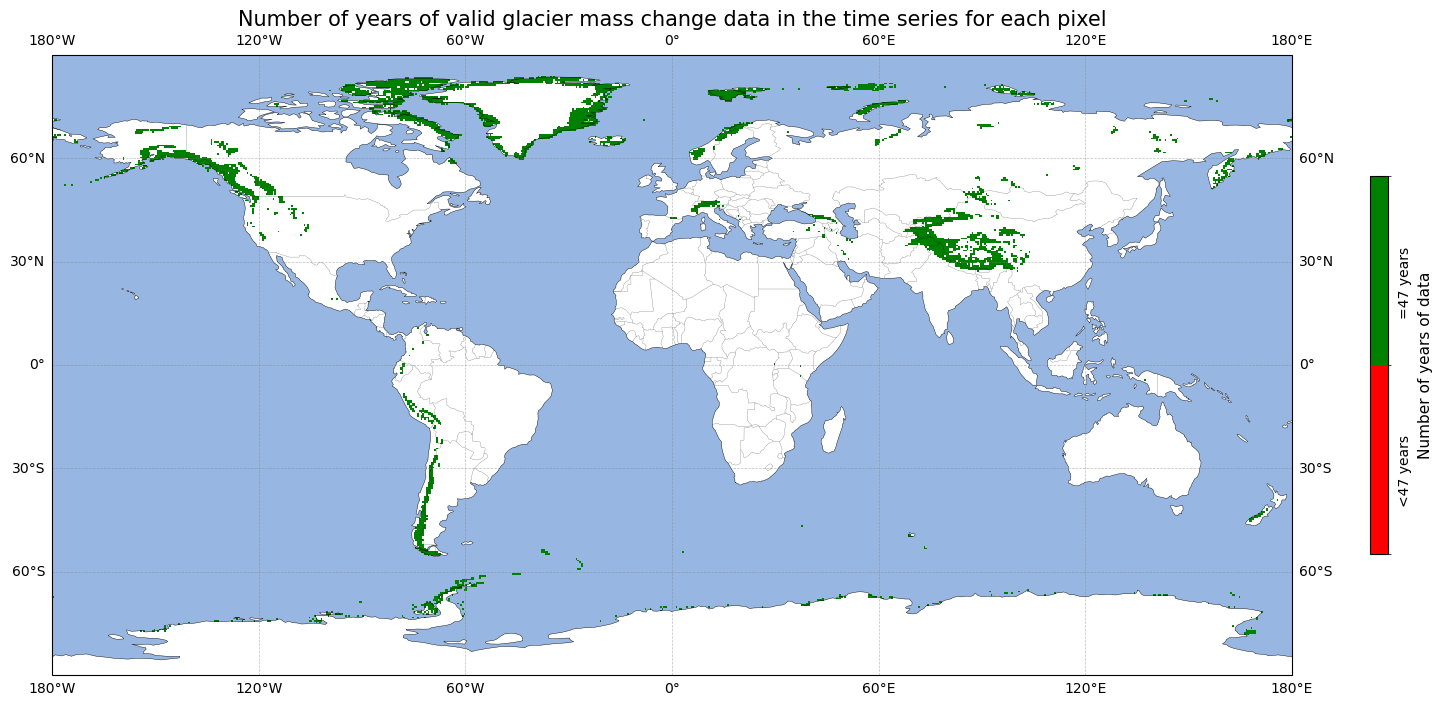

In [133]:
# Define the boundaries for the colorbar
bounds = [0, 0.5, 1]  # Green (0), Red (1)
cmap = mpl.colors.ListedColormap(['red', 'green'])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
lon_grid, lat_grid = np.meshgrid(ds["longitude"].values, ds["latitude"].values)
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linewidth=0.25, alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
non_nan_counts = ds_timeseries["glacier_mass_change_gt"].count(dim="time").where(ds_timeseries["glacier_mass_change_gt"].count(dim="time") != 0)
# Plot the data
im = ax.pcolormesh(ds_timeseries["longitude"].values, ds_timeseries["latitude"].values, non_nan_counts, 
                   transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
cb = fig.colorbar(im, ax=ax, shrink=0.49, label='Number of years of data', spacing="uniform")
cb.set_ticks([0.3, 0.8])  # Set the ticks at the midpoints of the ranges
cb.set_ticklabels([f'<{np.shape(ds_timeseries["time"])[0]} years', f'={np.shape(ds_timeseries["time"])[0]} years'])  # Set the tick labels
cb.ax.yaxis.set_tick_params(rotation=90)
cb.ax.yaxis.set_tick_params(length=0)
plt.title('Number of years of valid glacier mass change data in the time series for each pixel', fontsize=15)
plt.show()

Let us have this number quantified:

In [135]:
count_time = (non_nan_counts == np.shape(ds_timeseries['time'])[0]).sum().values
count_nonnan = np.sum(~np.isnan(non_nan_counts).values)
print(f"The number of pixels that have a time series of valid glacier mass change data of {np.shape(ds_timeseries['time'])[0]} years, which is the total number of years in the dataset, is {(100*count_time/count_nonnan):.2f}%.")

The number of pixels that have a time series of valid glacier mass change data of 47 years, which is the total number of years in the dataset, is 100.00%.


In other words, from the above analysis it becomes clear that the dataset exhibits a consistently complete temporal coverage, with no temporal data gaps, which allows for reliable quantifications of glacier mass change trends. The temporal resolution of 1 year is also consitent with the minimal threshold value proposed by GCOS (2022), although the ultimate goal would be to have glacier mass changes at a monthly time scale.

Although the numbers above suggest a quality-rich dataset in terms of temporal coverage and extent, some potential limitations include:
- Although a threshold spatial resolution is not given by GCOS (2022), it is worth noting that data can not be consulted at the individual glacier-scale, instead the data are presented at a 0.5 degree global grid.
- It is impossible to determine the number of glaciers in a particular year for which mass or elevation changes are available. It is hence not possible to determine which regions are under/oversampled in space or time, or to quantify how many glacier mass change data are derived from the glaciological or geodetic methods respectively.
- The hydrological year varies from region to region, meaning that annual values from a pixel or region in the northern hemisphere are temporally not fully consistent with annual values from a pixel or region in the southern hemisphere.
- Data were furthermore measured and generated by different institutes/research groups and from different methods (i.e. the in-situ glaciological and satellite-based geodetic methods). As such, they were (with a high degree of certainty) not compiled in a fully consistent way for the entire dataset.

Quantitative details about the sampling density (i.e. number of sampled glaciers per grid point) are thus not given in the dataset. An indication of the global distribution of glaciological mass change and geodetic elevation change observations from the WGMS Fluctuations of Glaciers database (applicable for version WGMS-FoG-2022-09) is, however, available from the ECMWF Confluence Wiki. The figure below shows visual representation of the global distribution of glacier mass change observations from the glaciological and geodetic (elevation change) samples available from the WGMS. While the glaciological sample covers a ca. 500 glaciers only, the geodetic sample covers more than 200,000 glaciers around the globe. 

![Glacier Mass Change](https://confluence.ecmwf.int/download/attachments/400511880/worddav7f0b50ea682a4006df7d06a1db608334.png?version=1&modificationDate=1713359791909&api=v2)

Let us compare the number of sampled glaciers (208,500 in this dataset) to the total amount of glaciers in the RGIv6.0 dataset (RGI Consortium, 2017):

In [148]:
print(f"The total amount of glaciers used in the glacier mass change dataset is 208500, which is {100*(208500)/(216429):.2f}% of the amount of glaciers in the RGIv6.0 dataset.")

The total amount of glaciers used in the glacier mass change dataset is 208500, which is 96.34% of the amount of glaciers in the RGIv6.0 dataset.


A potential scarce observational sample can introduce significant biases and uncertainties into the analysis of long-term trends in glacier mass changes. It can lead to inaccurate representations of the trends and potential misinterpretations of regional/global climate signals. Ensuring a robust and representative observational sample is therefore crucial for reliable trend analysis and accurate assessments of climate change impacts on glaciers. The large amount of glaciers used in the glacier mass change estimates of this dataset thus indicates that long-term trends are, with a high degree of certainty, not biased due to a  scarce observational sample. It must be noted that, however, the total number of glaciers is a rather arbitrary quantity due to several reasons (how do glacier tributaries need to be treated, are rock glaciers included, how to divide glacier complexes into separate entities, from which threshold size onwards can we speak of a glacier, etc.), which is out of scope for this notebook.

### Spatial distribution of glacier mass change (linear and quadratic) trends

Let us plot the cumulative sum of glacier mass changes, as well as their linear trends and accelarations over time:

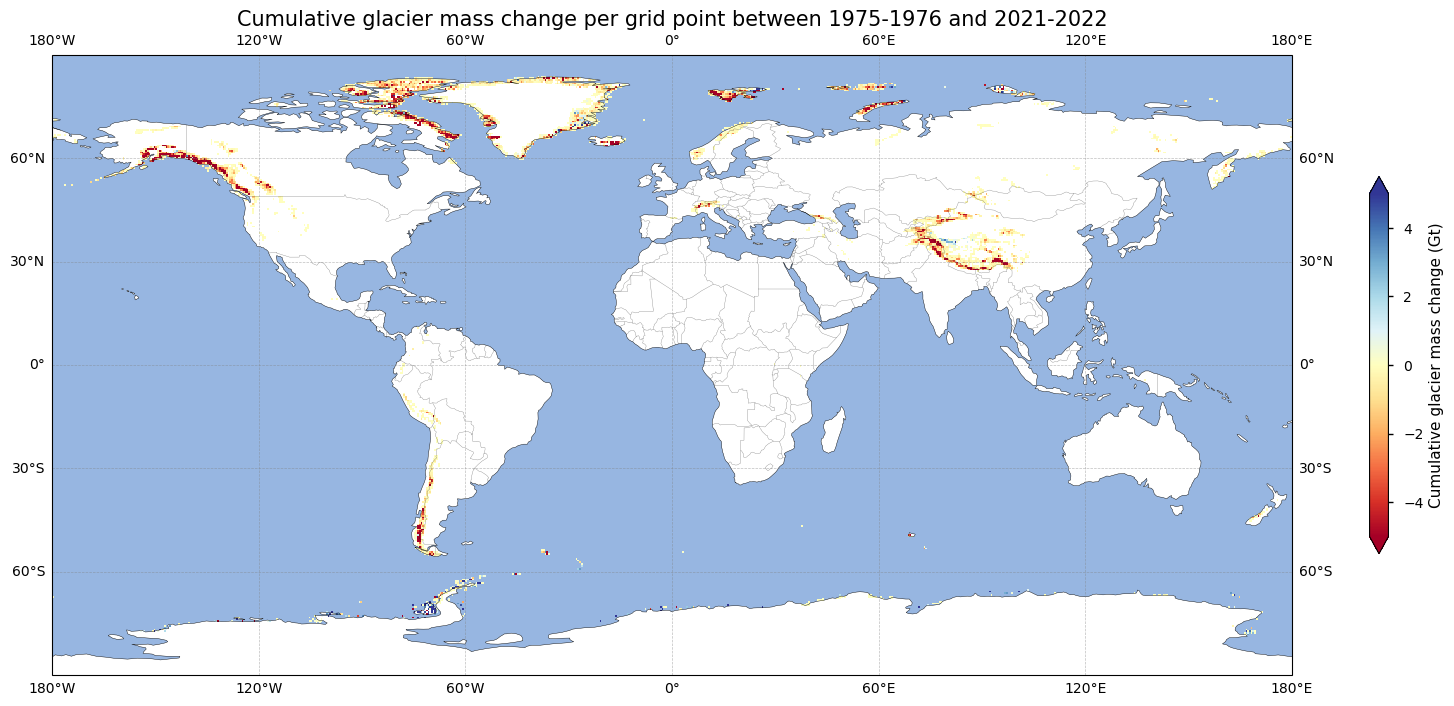

In [58]:
# Plot the gridded data
lon_grid, lat_grid = np.meshgrid(ds["longitude"].values, ds["latitude"].values)
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
im=ax.pcolormesh(ds["longitude"].values, ds["latitude"].values, ((ds)["glacier_mass_change_gt"]).where((ds)['glacier_mass_change_gt'] != 0, np.nan), transform=ccrs.PlateCarree(), cmap = mpl.cm.RdYlBu, vmin=-5,vmax=5)
fig.colorbar(im,ax=ax,extend='both',shrink=0.49,label='Cumulative glacier mass change (Gt)')
plt.title('Cumulative glacier mass change per grid point between ' + period_start.replace("_", "-") + ' and ' + period_stop.replace("_", "-"), fontsize=15)
plt.show()

Let us plot the linear trends:

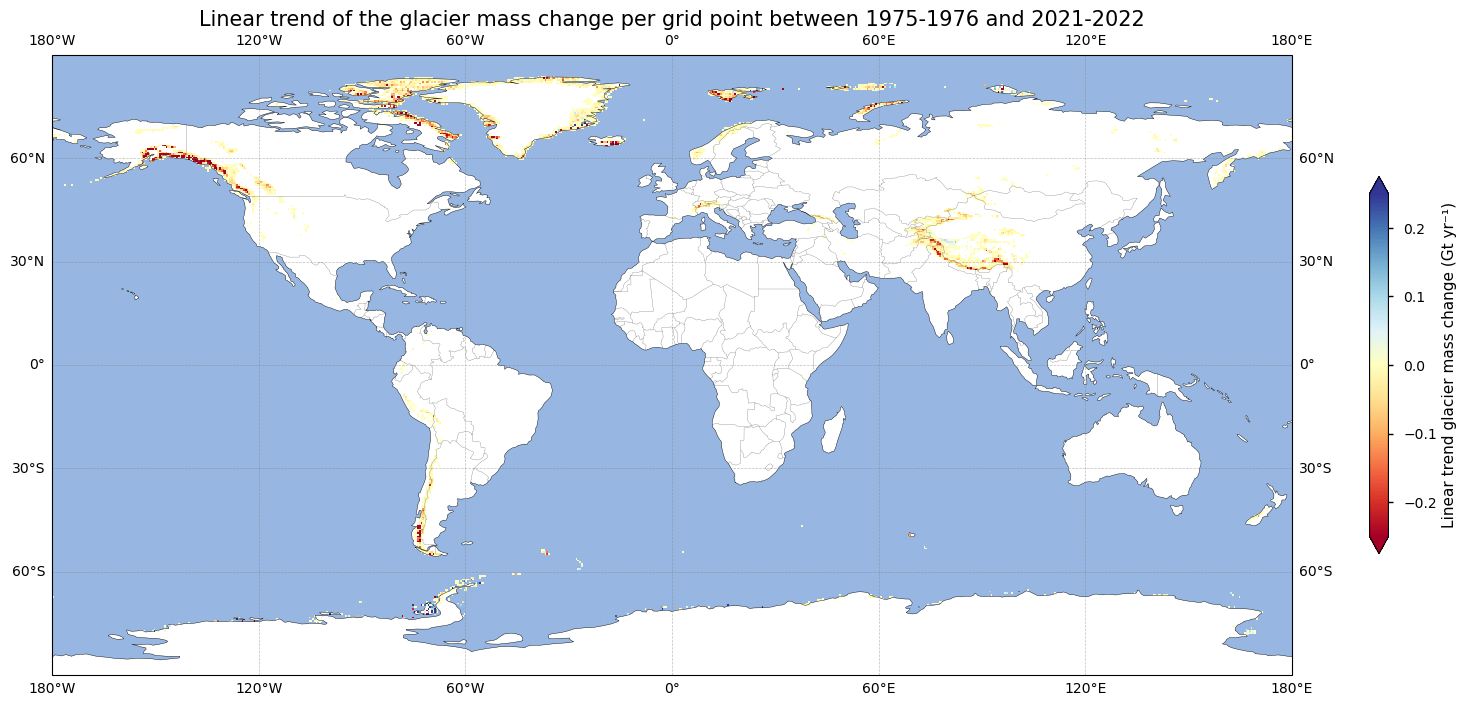

In [97]:
# Plot the gridded data
lon_grid, lat_grid = np.meshgrid(ds["longitude"].values, ds["latitude"].values)
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
im=ax.pcolormesh(ds["longitude"].values, ds["latitude"].values, (ds)["Slope"].where((ds)['glacier_mass_change_gt'] != 0, np.nan), transform=ccrs.PlateCarree(), cmap = mpl.cm.RdYlBu, norm=mpl.colors.TwoSlopeNorm(vmin=-0.25,vcenter=0,vmax=0.25))
cb=fig.colorbar(im,ax=ax,extend='both',shrink=0.49,label='Linear trend glacier mass change (Gt yr⁻¹)')
cb.ax.set_yscale('linear')
plt.title('Linear trend of the glacier mass change per grid point between ' + period_start.replace("_", "-") + ' and ' + period_stop.replace("_", "-"), fontsize=15)
plt.show()

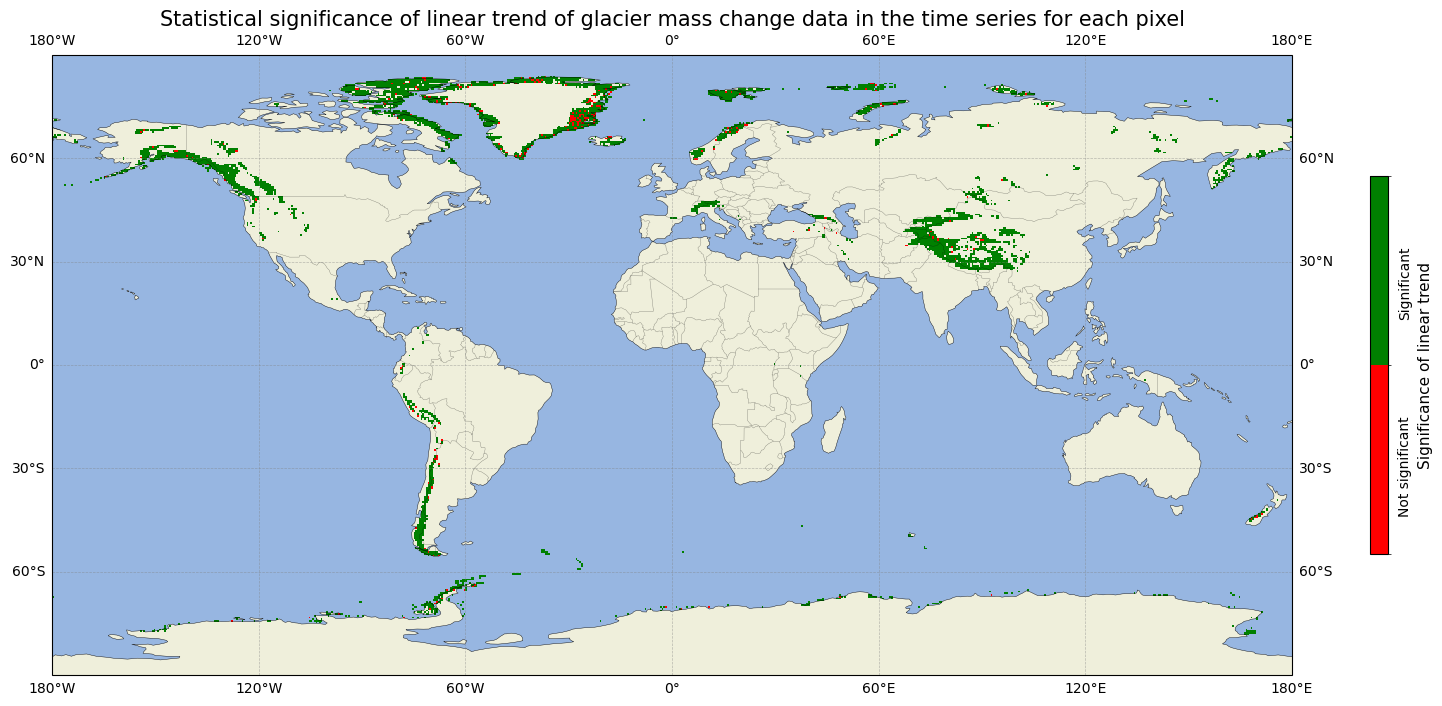

In [80]:
# Plot the gridded data
significance_level = 0.05
significant = ds["Pvalue1"].values < significance_level
# Define the boundaries for the colorbar
bounds = [0, 0.5, 1]  # Green (0), Red (1)
cmap = mpl.colors.ListedColormap(['red', 'green'])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
lon_grid, lat_grid = np.meshgrid(ds["longitude"].values, ds["latitude"].values)
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linewidth=0.25, alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
significance = (ds["Pvalue1"] < significance_level).where(ds["glacier_mass_change_gt"] != 0)
# Plot the data
im = ax.pcolormesh(ds["longitude"].values, ds["latitude"].values, significance, 
                   transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
cb = fig.colorbar(im, ax=ax, shrink=0.49, label='Significance of linear trend', spacing="uniform")
cb.set_ticks([0.35, 0.80])  # Set the ticks at the midpoints of the ranges
cb.set_ticklabels([f'Not significant', f'Significant'])  # Set the tick labels
cb.ax.yaxis.set_tick_params(rotation=90)
cb.ax.yaxis.set_tick_params(length=0)
plt.title('Statistical significance of linear trend of glacier mass change data in the time series for each pixel', fontsize=15)
plt.show()

We can do the same for the accelerations:

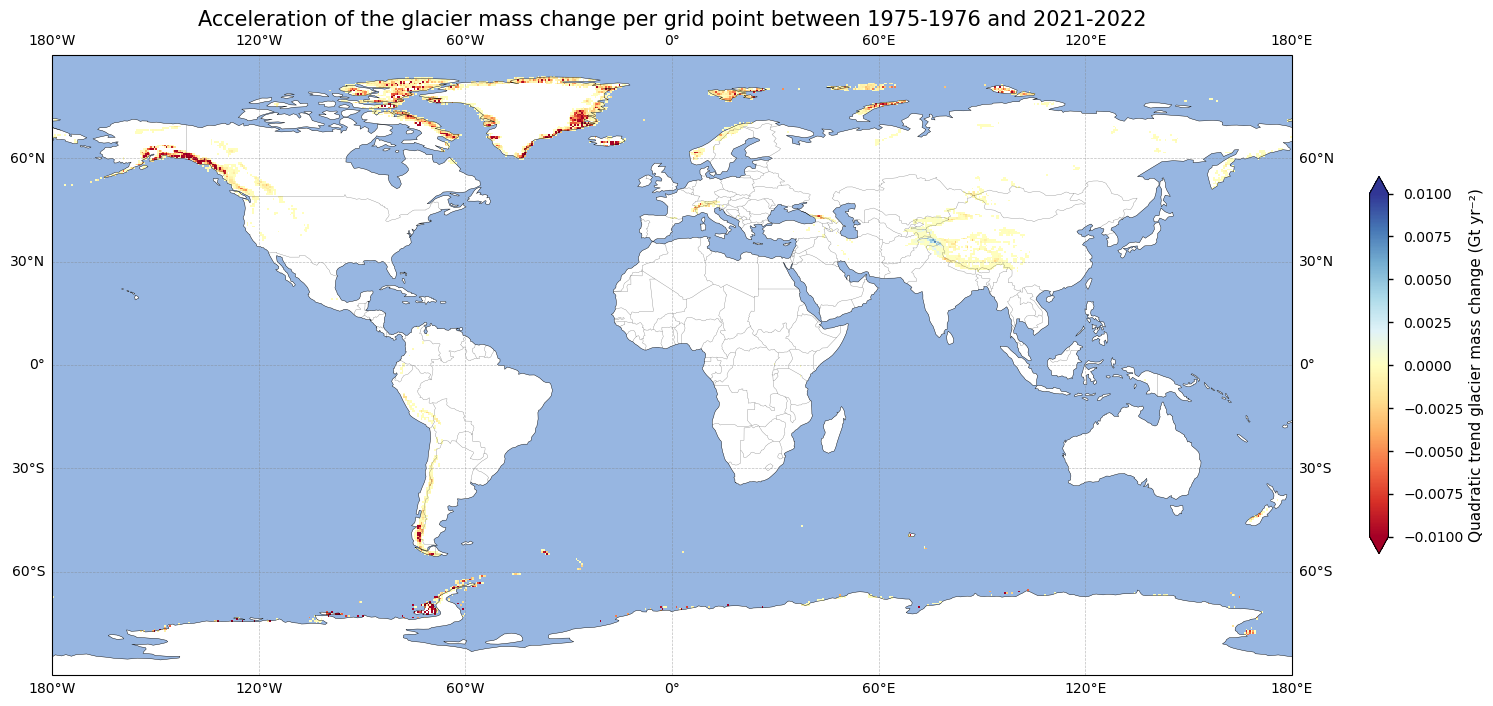

In [98]:
# Plot the gridded data
lon_grid, lat_grid = np.meshgrid(ds["longitude"].values, ds["latitude"].values)
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
im=ax.pcolormesh(ds["longitude"].values, ds["latitude"].values, (ds)["Acceleration"].where((ds)['glacier_mass_change_gt'] != 0, np.nan), transform=ccrs.PlateCarree(), cmap = mpl.cm.RdYlBu, norm=mpl.colors.TwoSlopeNorm(vmin=-0.01,vcenter=0,vmax=0.01))
cb=fig.colorbar(im,ax=ax,extend='both',shrink=0.49,label='Quadratic trend glacier mass change (Gt yr⁻²)')
cb.ax.set_yscale('linear')
plt.title('Acceleration of the glacier mass change per grid point between ' + period_start.replace("_", "-") + ' and ' + period_stop.replace("_", "-"), fontsize=15)
plt.show()

## If you want to know more

### Key resources

- "Glacier mass change gridded data from 1976 to present derived from the Fluctuations of Glaciers Database" on the CDS

### References